### House Prices - Advanced Regression Techniques
Data:
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [1]:
import os
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import cross_validate, cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,\
GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import pickle
randomstate = 0

In [2]:
# save figures for report
save_fig = True
fig_path = 'figs/'
if save_fig:
    os.makedirs(fig_path, exist_ok=True) 
    
# export predictions for scoring
save_submission = True
sub_path = 'submissions/'
if save_submission:
    os.makedirs(sub_path, exist_ok=True) 

### Data preparation, exploration, visualization

In [3]:
# data overview
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv', index_col=['Id'])
test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv', index_col=['Id'])
df = pd.concat([train, test], axis=0, sort=False)
print('training data:', train.shape)
train.info()
print('\ntest data:', test.shape)
test.info()
# there are missing data in both train and test sets

training data: (1460, 80)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-nu

In [4]:
# confirm that id is unique
assert train.index.nunique()==len(train)
assert test.index.nunique()==len(test)

In [5]:
# duplicated rows
print(f'Number of duplicate rows (all duplicates) in training set: {train.duplicated(keep=False).sum()}')

Number of duplicate rows (all duplicates) in training set: 0


In [6]:
# descriptive stats: 37 continuous variables
train.describe().round()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.0,1201.0,1460.0,1460.0,1460.0,1460.0,1460.0,1452.0,1460.0,1460.0,...,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0
mean,57.0,70.0,10517.0,6.0,6.0,1971.0,1985.0,104.0,444.0,47.0,...,94.0,47.0,22.0,3.0,15.0,3.0,43.0,6.0,2008.0,180921.0
std,42.0,24.0,9981.0,1.0,1.0,30.0,21.0,181.0,456.0,161.0,...,125.0,66.0,61.0,29.0,56.0,40.0,496.0,3.0,1.0,79443.0
min,20.0,21.0,1300.0,1.0,1.0,1872.0,1950.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,34900.0
25%,20.0,59.0,7554.0,5.0,5.0,1954.0,1967.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,129975.0
50%,50.0,69.0,9478.0,6.0,5.0,1973.0,1994.0,0.0,384.0,0.0,...,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,163000.0
75%,70.0,80.0,11602.0,7.0,6.0,2000.0,2004.0,166.0,712.0,0.0,...,168.0,68.0,0.0,0.0,0.0,0.0,0.0,8.0,2009.0,214000.0
max,190.0,313.0,215245.0,10.0,9.0,2010.0,2010.0,1600.0,5644.0,1474.0,...,857.0,547.0,552.0,508.0,480.0,738.0,15500.0,12.0,2010.0,755000.0


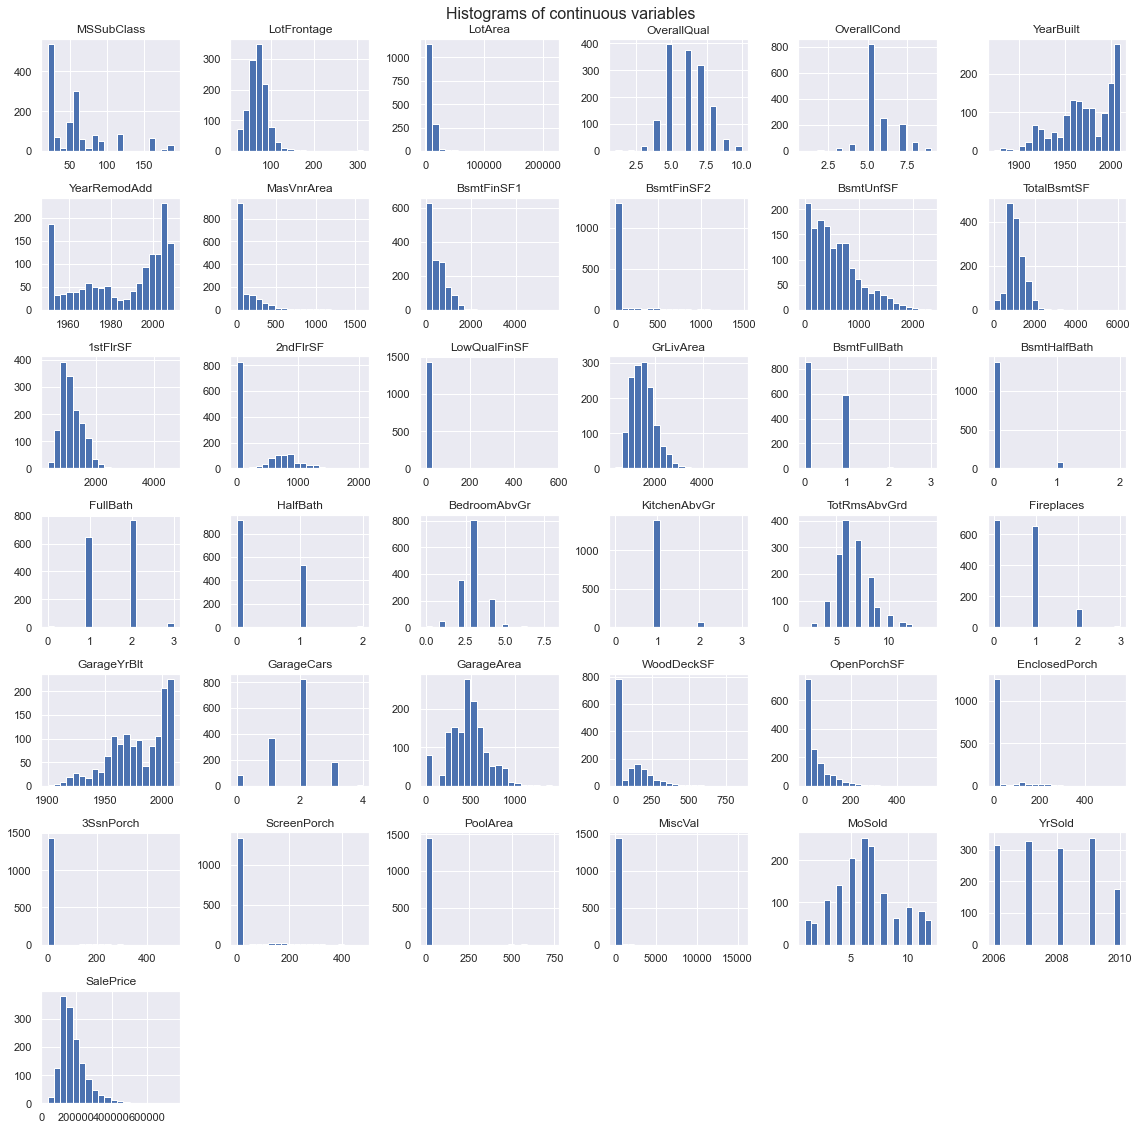

In [7]:
# examine distributions of continuous variables
train.hist(figsize=(16, 16), bins=20)
plt.suptitle('Histograms of continuous variables', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.gcf().tight_layout()
if save_fig:
    plt.savefig(fig_path+'cont_hist.pdf', format='pdf', bbox_inches='tight')

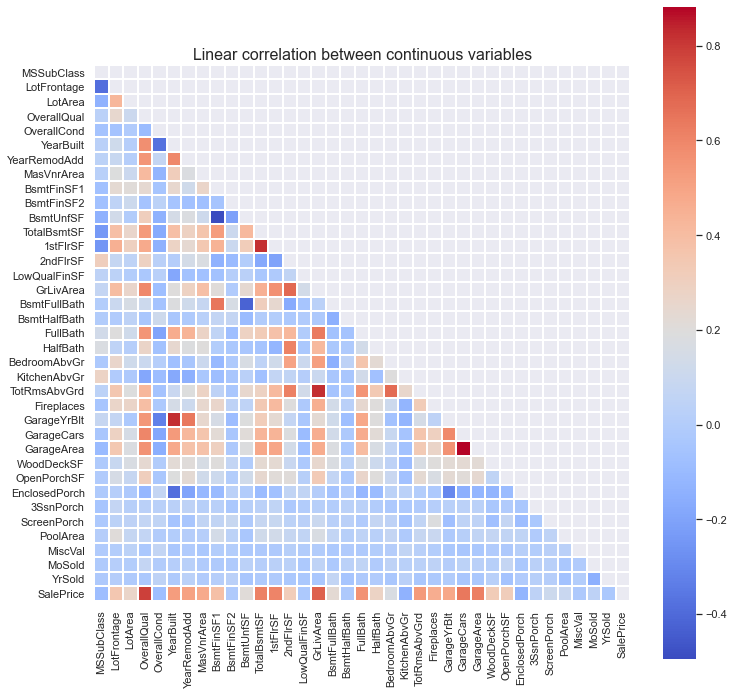

In [8]:
# linear correlation between continuous variables
corr = train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, cmap='coolwarm', square=True, lw=1, ax=ax)
ax.set_title('Linear correlation between continuous variables', fontsize=16)
plt.show()
if save_fig:
    fig.savefig(fig_path+'corr.pdf', format='pdf', bbox_inches='tight')

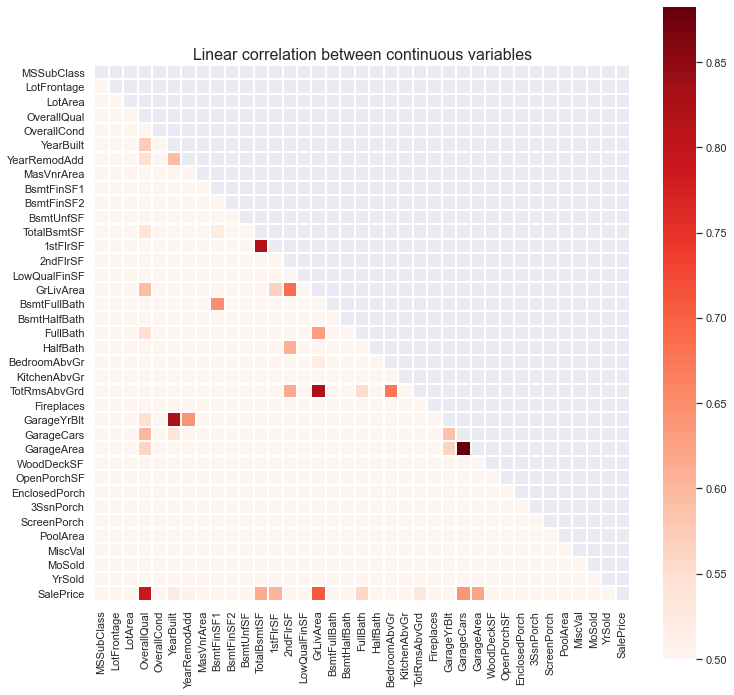

In [9]:
# linear correlation between continuous variables
# focus on positive linear correlations
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, cmap='Reds', square=True, vmin=0.5, lw=1, ax=ax)
ax.set_title('Linear correlation between continuous variables', fontsize=16)
plt.show()
if save_fig:
    fig.savefig(fig_path+'corrpos.pdf', format='pdf', bbox_inches='tight')

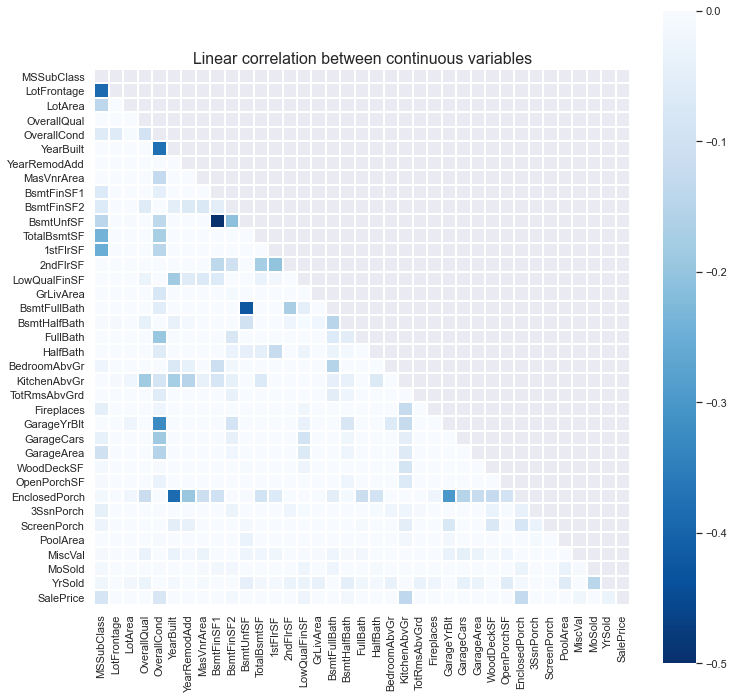

In [10]:
# linear correlation between continuous variables
# focus on negative linear correlations
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, cmap='Blues_r', square=True, vmin=-0.5, vmax=0, lw=1, ax=ax)
ax.set_title('Linear correlation between continuous variables', fontsize=16)
plt.show()
if save_fig:
    fig.savefig(fig_path+'corrneg.pdf', format='pdf', bbox_inches='tight')

In [11]:
# top 10 positive and negative linear correlations with SalePrice
corr.abs()['SalePrice'].sort_values(ascending=False)[1:].nlargest(10)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

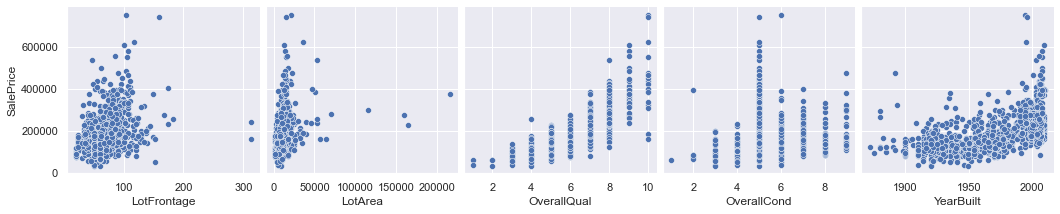

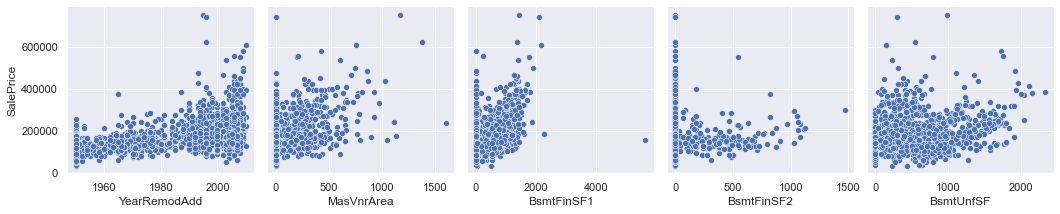

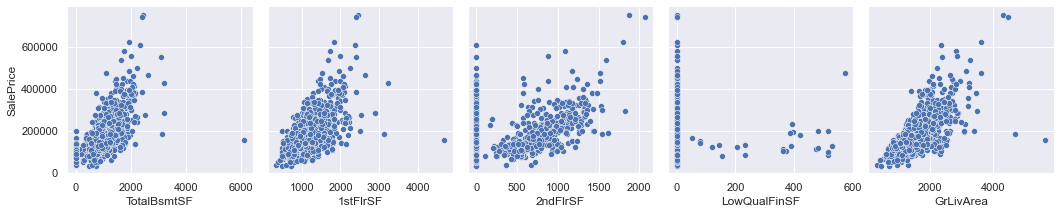

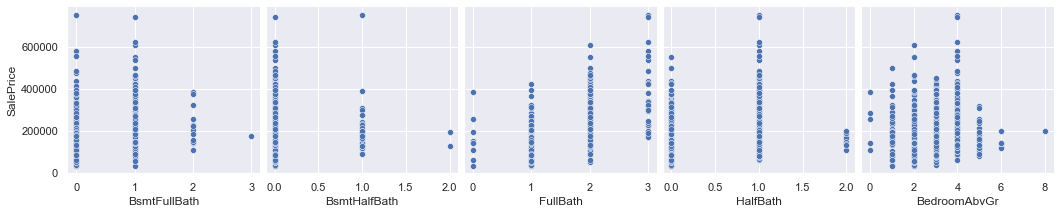

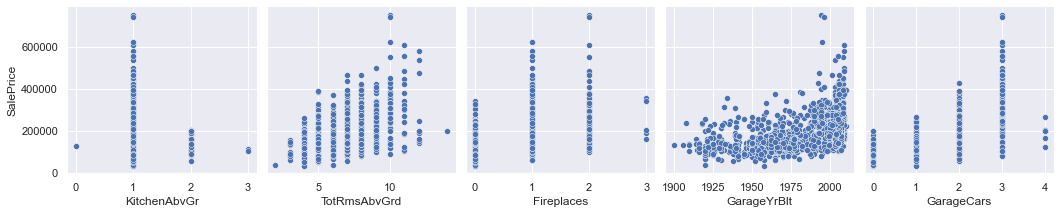

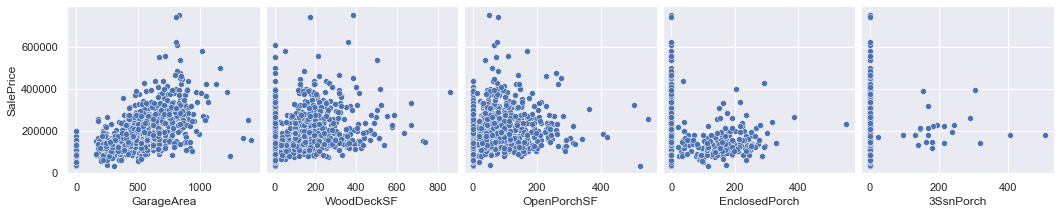

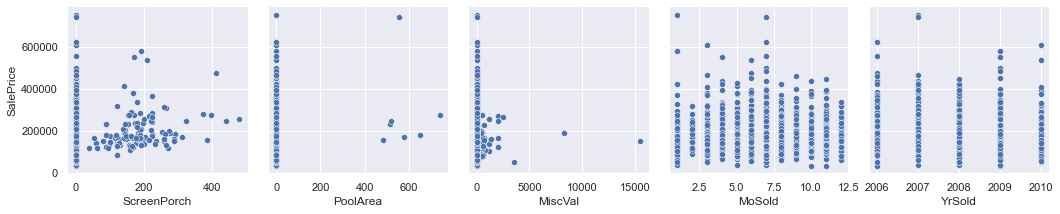

In [12]:
# examine relationship with the target variable, continuous variables
cols2plot = train.select_dtypes(include=np.number).columns
cols2plot = cols2plot.delete([0, 36]) # MSSubClass, SalePrice do not need to be plotted
for nn in range(1, 8):
    cols = np.arange(5*(nn-1), 5*nn)
    g = sns.pairplot(train, y_vars='SalePrice', x_vars=cols2plot[cols], height=3)
    if save_fig:
        g.savefig(fig_path+'pairplot_'+str(nn)+'.pdf', format='pdf', bbox_inches='tight')

* MSSubClass (type of dwelling) should be categorical
* MoSold, and YrSold could also be categorical, although they show weak association with the target variable and would probably not be selected or have a large effect in the models
* Some others variables such as # rooms and baths could be treated as numeric (math could be performed) or categorical
* Some features are highly skewed with mostly zeros (PoolArea, MiscVal)

In [13]:
# descriptive stats: 43 categorical variables
train.describe(include='O').round()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


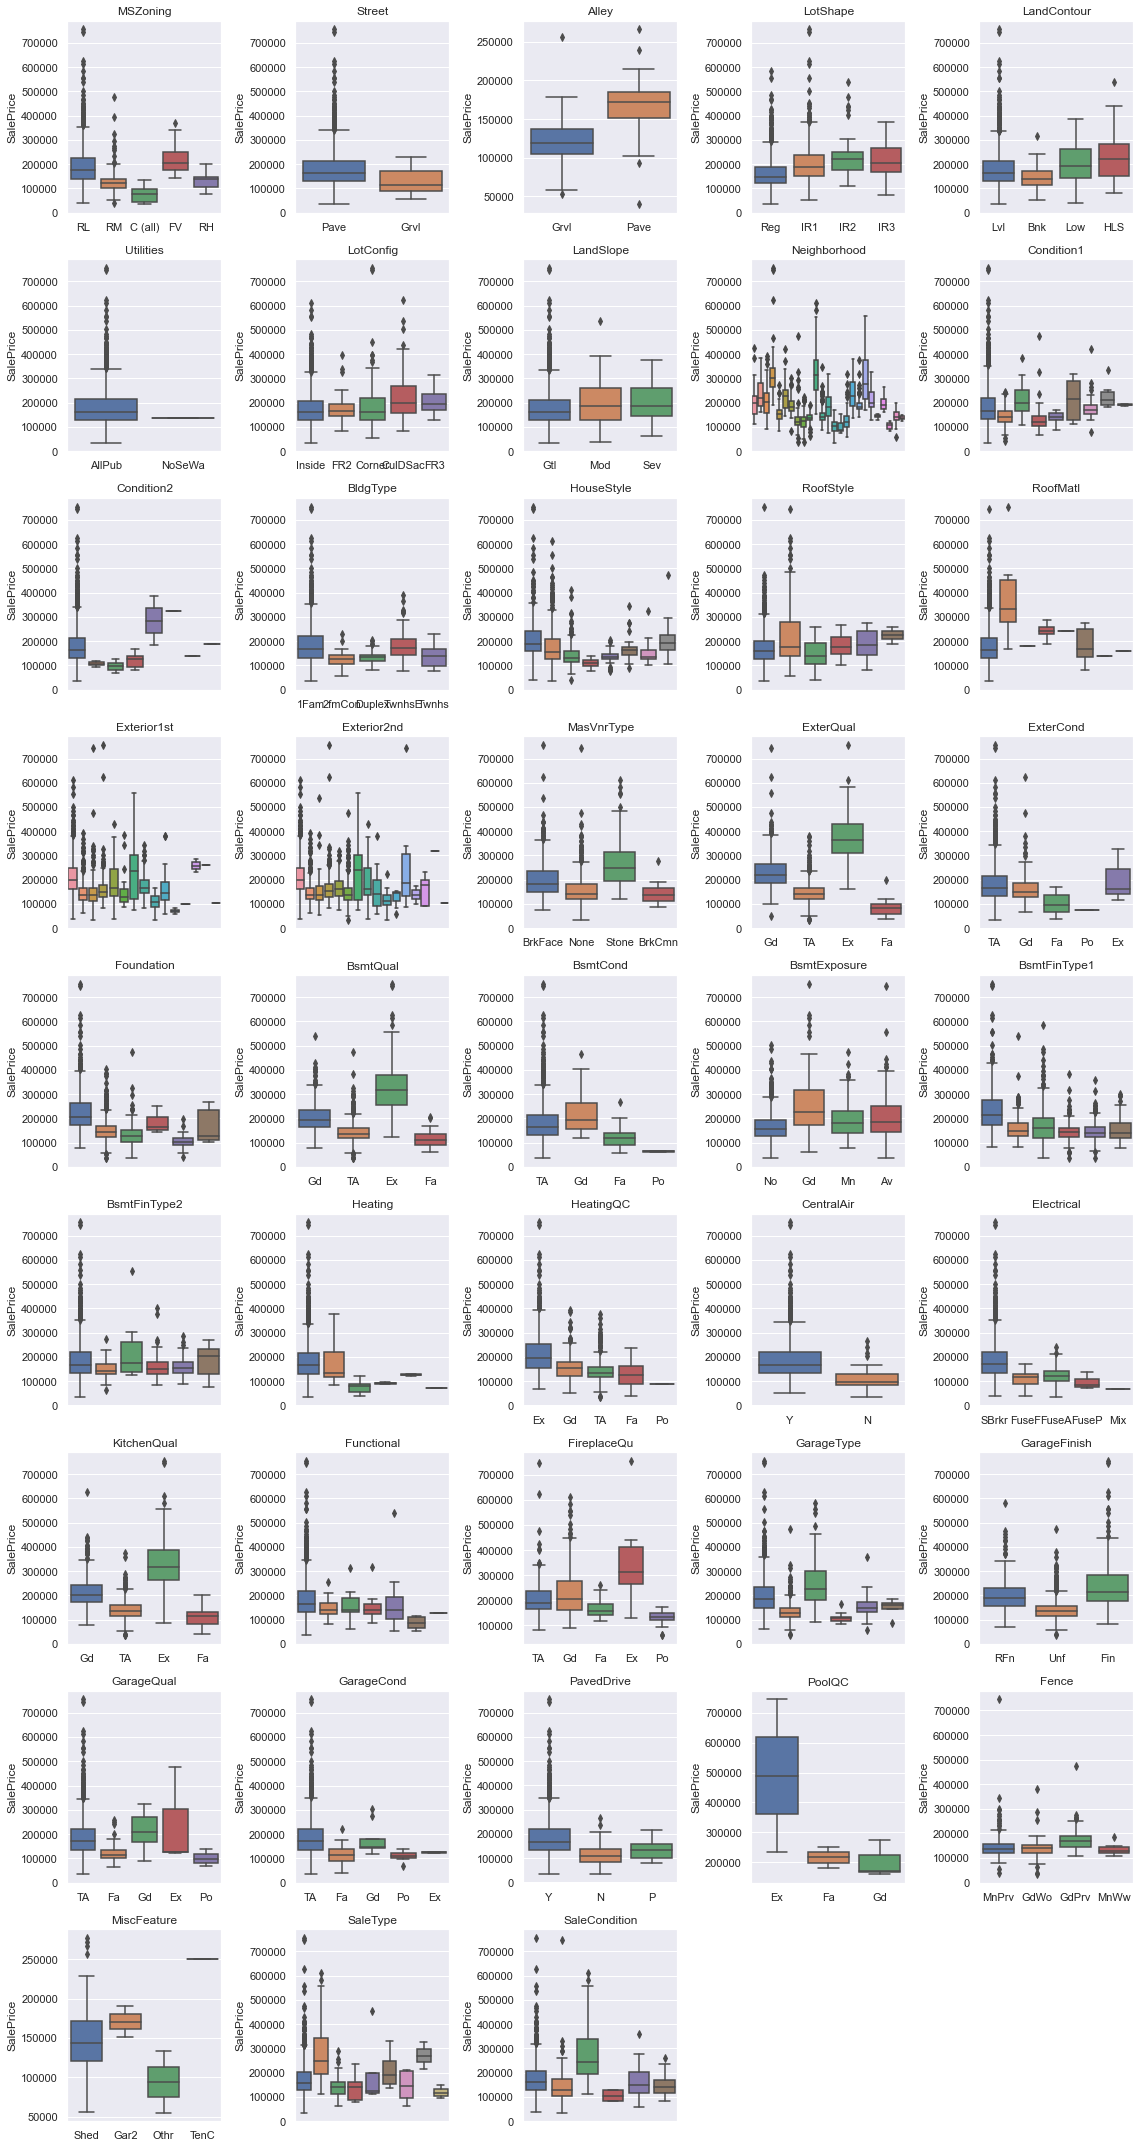

In [14]:
# examine relationship with the target variable, categorical variables
cols2plot = train.select_dtypes(include='O').columns
fig, ax = plt.subplots(figsize=(16, 30))
for ii, cc in enumerate(cols2plot, 1):
    plt.subplot(9, 5, ii) 
    g = sns.boxplot(x=cc, y='SalePrice', data=train)
    if len(g.get_xticklabels())>5: # no space to display xlabels; remove to avoid confusion
        g.axes.xaxis.set_visible(False)
    g.set(title=cc, xlabel='')
fig.tight_layout()
plt.show()
if save_fig:
    fig.savefig(fig_path+'saleprice_boxplot.pdf', format='pdf', bbox_inches='tight')

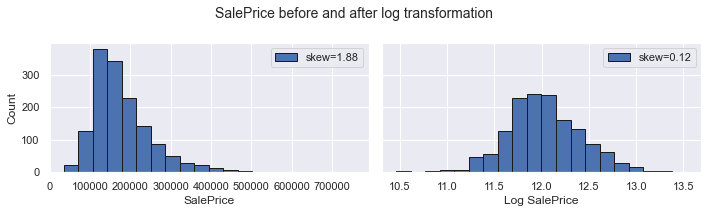

In [15]:
# target variable
fig, axs = plt.subplots(1,2, figsize=(10,3), sharey=True)
axs[0].hist(train['SalePrice'], bins=20, ec='k', label='skew={:.2f}'.format(train['SalePrice'].skew()))
axs[1].hist(np.log1p(train['SalePrice']), bins=20, ec='k', label='skew={:.2f}'.format(np.log1p(train['SalePrice']).skew()))
for ax in axs: ax.legend()
axs[0].set(xlabel='SalePrice', ylabel='Count')
axs[1].set(xlabel='Log SalePrice')
plt.suptitle('SalePrice before and after log transformation', fontsize=14)
plt.subplots_adjust(top=0.9)
fig.tight_layout()
plt.show()
if save_fig:
    fig.savefig(fig_path+'SalePrice.pdf', format='pdf', bbox_inches='tight')

34 variables with missing values: 
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']

variables with most missing values (fraction):
PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
SalePrice       0.499829
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageFinish    0.054471
GarageQual      0.054471
GarageYrBlt     0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.0

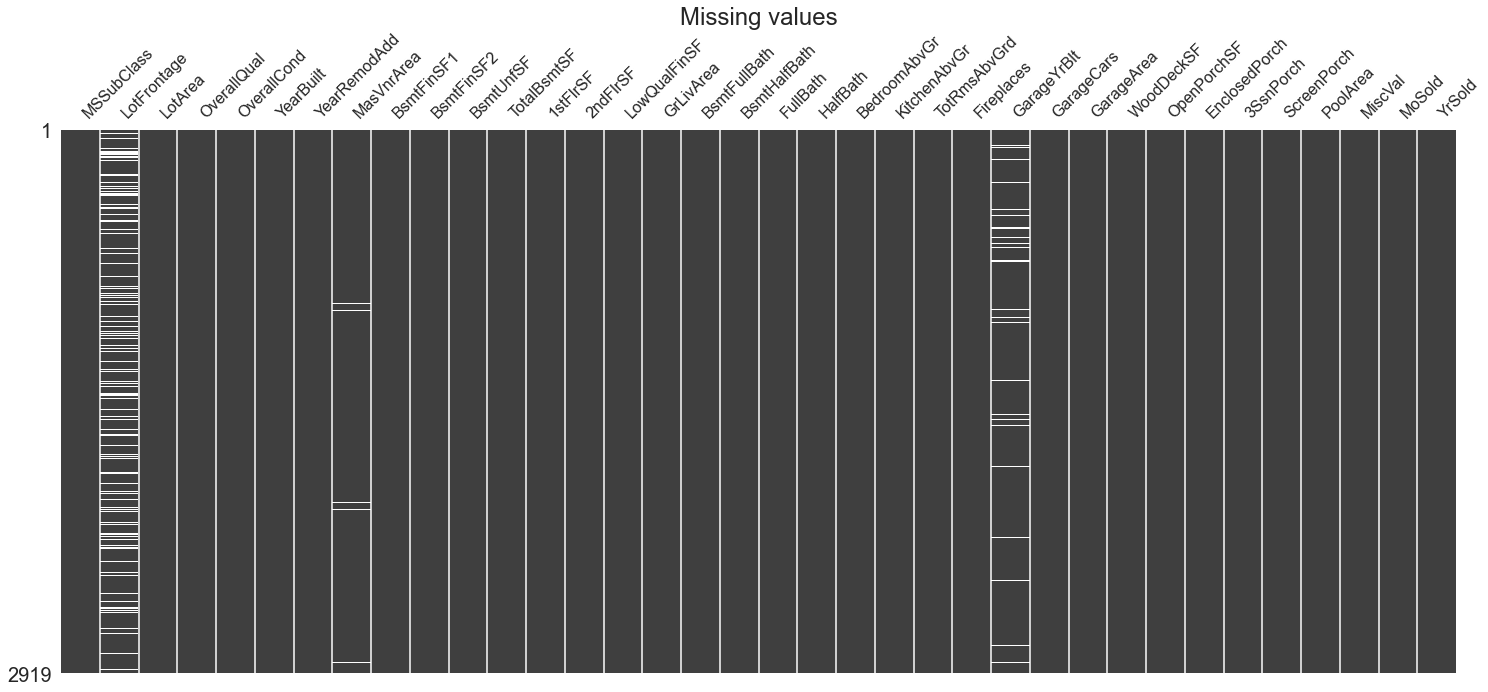

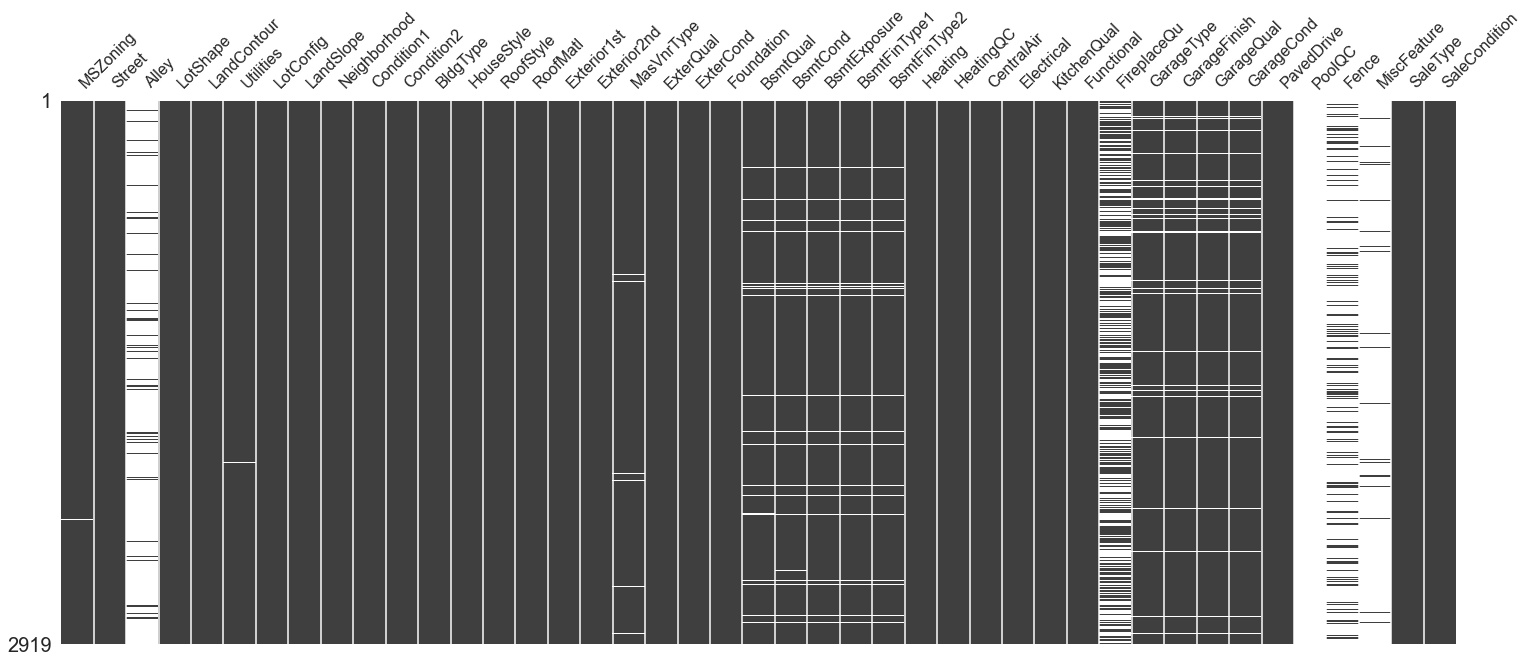

In [16]:
# missing values, train + test set
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [xx for xx in num_cols if xx not in ['SalePrice']]
cat_cols = [xx for xx in df.columns if xx not in num_cols and xx not in ['SalePrice']]
ax = msno.matrix(df[num_cols], sparkline=False)
ax.set_title('Missing values', fontsize=24)
if save_fig:
    ax.get_figure().savefig(fig_path+'msno_num.png', format='png', bbox_inches='tight')
ax = msno.matrix(df[cat_cols], sparkline=False)
if save_fig:
    ax.get_figure().savefig(fig_path+'msno_cat.png', format='png', bbox_inches='tight')
    
missing_cols = [xx for xx in df.columns[df.isna().sum()>0] if xx!='SalePrice']
print('{} variables with missing values: '
.format(len(missing_cols)))
print(missing_cols)

print('\nvariables with most missing values (fraction):')
print(df.isna().sum().sort_values(ascending=False).nlargest(20)/len(df))

In [17]:
# missing columns in train
missing_cols_train = [xx for xx in train.columns[train.isna().sum()>0] if xx!='SalePrice']
print('{} variables with missing values in training data: '
.format(len(missing_cols_train)))
print(missing_cols_train)

19 variables with missing values in training data: 
['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [18]:
# missing columns in test
missing_cols_test = [xx for xx in test.columns[test.isna().sum()>0] if xx!='SalePrice']
print('{} variables with missing values in test data: '
.format(len(missing_cols_test)))
print(missing_cols_test)

33 variables with missing values in test data: 
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


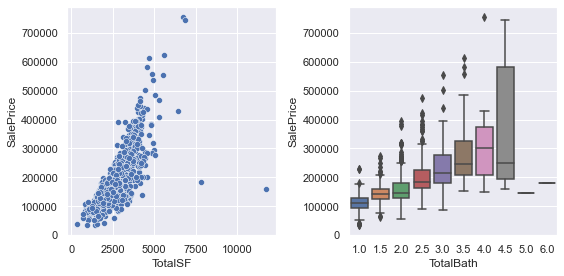

In [19]:
# feature engineering
# living area and bathrooms are associated with higher SalePrice
# plot total square feet and total number of bathrooms vs. SalePrice
tmp = train.copy()
tmp['TotalSF'] = tmp['TotalBsmtSF']+tmp['1stFlrSF']+tmp['2ndFlrSF']
tmp['TotalBath'] = tmp['FullBath']+0.5*tmp['HalfBath']+tmp['BsmtFullBath']+0.5*tmp['BsmtHalfBath']
fig, axs = plt.subplots(1,2, figsize=(8,4))
sns.scatterplot(x='TotalSF', y='SalePrice', data=tmp, ax=axs[0])
sns.boxplot(x='TotalBath', y='SalePrice', data=tmp, ax=axs[1])
fig.tight_layout()
plt.show()
if save_fig:
    fig.savefig(fig_path+'totalSFandBath.pdf', format='pdf', bbox_inches='tight')

#### Feature cleaning and engineering
Construct transformers that can be used in a feature cleaning/engineering pipeline

In [20]:
# convert to categorical (e.g. MSSubClass)
class ToCat(BaseEstimator, TransformerMixin):
    def __init__(self, fns):  
        self.fns = fns
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        for fn in self.fns:
            X_[fn] = X_[fn].astype(str)
        return X_

In [21]:
# mode imputation
class ModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fns):  
        self.fns = fns
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        for fn in self.fns:
            X_[fn] = X_[fn].fillna(train[fn].mode()[0])
        return X_

In [22]:
# impute with 'NA'
class NAImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fns):  
        self.fns = fns
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        for fn in self.fns:
            X_[fn] = X_[fn].fillna('NA')
        return X_

In [23]:
# median impututation
class MedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fns):  
        self.fns = fns
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        for fn in self.fns:
            X_[fn] = X_[fn].fillna(train[fn].median())
#             X_[fn] = X_[fn].fillna(train[fn].mean())
        return X_

In [24]:
# impute with zero
class ZeroImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fns):  
        self.fns = fns
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        for fn in self.fns:
            X_[fn] = X_[fn].fillna(0)
        return X_

In [25]:
# simplify and consolidate categories
# Fa, Po to FP (combine fair and poor to "fair/poor")
class ConsolidateFaPo(BaseEstimator, TransformerMixin):
    def __init__(self, fns):  
        self.fns = fns
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        for fn in self.fns:
            X_[fn].replace(['Fa', 'Po'], ['FP', 'FP'], inplace=True)
        return X_

In [26]:
# add total SF and total baths 
class TotalSF_Bath(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        X_['TotalSF'] = X_['TotalBsmtSF']+X_['1stFlrSF']+X_['2ndFlrSF']
        X_['TotalBath'] = X_['FullBath']+0.5*X_['HalfBath']+X_['BsmtFullBath']+0.5*X_['BsmtHalfBath']
        return X_

In [27]:
# categorical variables that are suitable for imputing with NA
NAImputer_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
                  'Fence', 'MiscFeature',]

In [28]:
# variables that are suitable for mode imputation
ModeImputer_cols = ['MSZoning', 'MasVnrType', 'MasVnrArea', 'Electrical', 'BsmtFinSF1', 'GarageArea',
                    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                    'BsmtFinSF2',]

In [29]:
# variables that are suitable for median imputation
MedianImputer_cols = ['LotFrontage']

In [30]:
# variables that are suitable for imputing with zero
ZeroImputer_cols = ['GarageYrBlt', 'GarageCars']

In [31]:
# variables that are suitable for imputing with zero
ZeroImputer_cols = ['GarageYrBlt', 'GarageCars']

In [32]:
# variables to simplify and consolidate categories
ConsolidateFaPo_cols = ['HeatingQC', 'FireplaceQu', 'GarageQual', 'GarageCond']

In [33]:
# feature cleaning/engineering pipeline
pipe_clean = make_pipeline(NAImputer(NAImputer_cols), ModeImputer(ModeImputer_cols), 
                           MedianImputer(MedianImputer_cols), ZeroImputer(ZeroImputer_cols),
                           ConsolidateFaPo(ConsolidateFaPo_cols), ToCat(['MSSubClass']), TotalSF_Bath(),
                          )

#### Preprocessing
Transform and encode

In [34]:
# define scalers/transformers and encoders
train_clean = pipe_clean.fit_transform(train)
num_cols = train_clean.select_dtypes(include=np.number).columns.tolist()
num_cols = [xx for xx in num_cols if xx not in ['SalePrice']]
cat_cols = [xx for xx in df.columns if xx not in num_cols and xx not in ['SalePrice']]
print('continuous variables:\n', num_cols)
print('')
print('categorical variables:\n', cat_cols)

# power transformer
pipe_power = make_pipeline(PowerTransformer())
# one-hot encoder
pipe_onehot = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore',
                                                drop=None))

# preprocessing pipeline
pipe_preproc = ColumnTransformer(transformers=[
    ('power', pipe_power, num_cols),
    ('onehot', pipe_onehot, cat_cols),
], remainder='passthrough')

continuous variables:
 ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF', 'TotalBath']

categorical variables:
 ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional

In [35]:
# combine feature cleaning/engineering and preprocessing pipeline
pipe1 = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
])

In [36]:
# define X_train, y_train, X_test
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test

In [37]:
# workaround function for getting feature names from all transformers
# useful for transformers that do not provide a get_feature_names() method
# source: 
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/
# ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [38]:
# verify combined pipeline
train1 = pd.DataFrame(pipe1.fit_transform(X_train), 
                      index=train.index, columns=get_feature_names(pipe1['preprocess']))

# get original feature names from onehotencoder
onehotmap = dict(zip(['onehotencoder__'+xx for xx in
                      pipe1['preprocess'].transformers_[1][1]['onehotencoder'].get_feature_names().tolist()],
                     ['ohe__'+xx for xx in
                      pipe1['preprocess'].transformers_[1][1]['onehotencoder'].get_feature_names(cat_cols).tolist()]))

# examine preprocessed train
train1.rename(columns=onehotmap, inplace=True)
print(f'# missing values in train: {train1.isna().sum().sum()}')
train1

# missing values in train: 0


,power__LotFrontage,power__LotArea,power__OverallQual,power__OverallCond,power__YearBuilt,power__YearRemodAdd,power__MasVnrArea,power__BsmtFinSF1,power__BsmtFinSF2,power__BsmtUnfSF,...,ohe__SaleType_ConLw,ohe__SaleType_New,ohe__SaleType_Oth,ohe__SaleType_WD,ohe__SaleCondition_Abnorml,ohe__SaleCondition_AdjLand,ohe__SaleCondition_Alloca,ohe__SaleCondition_Family,ohe__SaleCondition_Normal,ohe__SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.146062,-0.141171,0.667499,-0.477387,1.151867,0.908055,1.230708,0.797537,-0.359384,-0.887576,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.546852,0.105609,-0.042192,2.011352,0.006695,-0.621670,-0.818452,1.011471,-0.359384,-0.434388,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.000631,0.413721,0.667499,-0.477387,1.055357,0.835594,1.193873,0.571325,-0.359384,-0.048083,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.397299,0.095490,0.667499,-0.477387,-1.629540,-0.863478,-0.818452,0.142272,-0.359384,0.183337,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.718695,0.877127,1.350924,-0.477387,1.007861,0.694898,1.333038,0.750541,-0.359384,0.077485,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,-0.295410,-0.266808,-0.042192,-0.477387,0.960863,0.694898,-0.818452,-1.353159,-0.359384,0.909505,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,0.760913,0.722071,-0.042192,0.440551,0.080711,-0.041619,1.130602,0.869532,2.782472,0.282161,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,-0.097163,-0.010330,0.667499,2.698415,-1.061347,1.134227,-0.818452,0.261742,-0.359384,0.790731,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
# check missing values in preprocessed test
print(f'# missing values in test: {pd.DataFrame(pipe1.transform(test)).isna().sum().sum()}')

# missing values in test: 0


### Modeling

In [40]:
# lists to save cross-validation results
model_list, rmse_m_list, rmse_s_list, rmsle_m_list, rmsle_s_list = [[] for xx in range(5)]

# function to get cross-validation scores for model pipelines
# metrics: RMSE and RMSLE
def get_cv_scores(model_pipeline, save_results=True):
    cv_scores = cross_validate(model_pipeline, X_train, y_train, 
                           scoring=['neg_root_mean_squared_error', 'neg_mean_squared_log_error'], 
                            cv=5, verbose=1, n_jobs=-1)
    
    if save_results:
        rmse_m_list.append(-cv_scores['test_neg_root_mean_squared_error'].mean())
        rmse_s_list.append(cv_scores['test_neg_root_mean_squared_error'].std())
        rmsle_m_list.append(np.sqrt(-cv_scores['test_neg_mean_squared_log_error']).mean())
        rmsle_s_list.append(np.sqrt(-cv_scores['test_neg_mean_squared_log_error']).std())

    print('RMSE: {}'.format(-cv_scores['test_neg_root_mean_squared_error'].round()))
    print('RMSE_mean: {:.0f}'.format(-cv_scores['test_neg_root_mean_squared_error'].mean()))
    print('RMSE_std: {:.0f}'.format(cv_scores['test_neg_root_mean_squared_error'].std()))
    print('')
    print('RMSLE: {}'.format(np.sqrt(-cv_scores['test_neg_mean_squared_log_error'])))
    print('RMSLE_mean: {:.6f}'.format(np.sqrt(-cv_scores['test_neg_mean_squared_log_error']).mean()))
    print('RMSLE_std: {:.6f}'.format(np.sqrt(-cv_scores['test_neg_mean_squared_log_error']).std()))
    
# function to get cross-validation scores for StackingRegressor
# only RMSLE returned because target is (manually) log transformed
def get_cv_scores2(model, save_results=True):
    cv_scores = cross_validate(model, X_train2, np.log1p(y_train), 
                           scoring=['neg_root_mean_squared_error'], 
                            cv=5, verbose=1, n_jobs=-1)
    
    if save_results:
        rmsle_m_list.append(-cv_scores['test_neg_root_mean_squared_error'].mean())
        rmsle_s_list.append(cv_scores['test_neg_root_mean_squared_error'].std())
        rmse_m_list.append(0)
        rmse_s_list.append(0)

    print('RMSLE: {}'.format(-cv_scores['test_neg_root_mean_squared_error']))
    print('RMSLE_mean: {:.6f}'.format(-cv_scores['test_neg_root_mean_squared_error'].mean()))
    print('RMSLE_std: {:.6f}'.format(cv_scores['test_neg_root_mean_squared_error'].std()))

In [41]:
# plot and get feature importances (top 20 features) 
def plot_importances(model_pipeline):
    model_name = str(model_pipeline['model'].regressor).split('(')[0].split('CV')[0]
    if hasattr(model_pipeline['model'].regressor_, 'coef_'):
        vv = model_pipeline['model'].regressor_.coef_
        plottitle = 'Top 20 features by coefficient magnitude\n'+model_name
    elif hasattr(model_pipeline['model'].regressor_, 'feature_importances_'):
        vv = model_pipeline['model'].regressor_.feature_importances_
        plottitle = 'Top 20 features by importance\n'+model_name
    
    df = pd.DataFrame({'Feature':[xx.split('__')[1] for xx in train1.columns],
                   'Coefficient':vv, 'Magnitude':np.abs(vv),})

    dftmp = df.sort_values(by='Magnitude', ascending=False)[:20]
    maxval = dftmp['Magnitude'].max()

    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(x='Coefficient', y='Feature', 
                data=dftmp.sort_values(by='Coefficient', ascending=False), 
                color='#4C72B0', ax=ax)
    ax.axvline(x=0, c='k', ls='--')
    if dftmp['Coefficient'].min()<0: ax.set_xlim([-maxval*1.05, maxval*1.05])
    ax.set_title(plottitle, fontsize=14)
    plt.show()

    if save_fig:
        fig.savefig(fig_path+'featimp_'+model_name+'.pdf', format='pdf', bbox_inches='tight')
        
    return dftmp

In [42]:
# hyperparameter tuning with optuna
# function to run study/tune hyperparameters
def tune(objective):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    params = study.best_params
    best_score = study.best_value
    print(f'Best score: {best_score} \nOptimized parameters: {params}')
    return params

# check for saved optimized params to save time and for reproducibility
try:
    with open('best_params.pickle', 'rb') as fh:
        best_params = pickle.load(fh)
except FileNotFoundError:
    pass

#### Ridge

In [43]:
# RidgeCV 
regressor = RidgeCV(alphas=np.logspace(-1, 2, 100, endpoint=True), 
                    scoring='neg_mean_squared_log_error', cv=5)

pipe_ridge = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
    ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1)),
])

model_list.append('Ridge')
# cross-validation
get_cv_scores(pipe_ridge)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RMSE: [20914. 31567. 26866. 21341. 53556.]
RMSE_mean: 30849
RMSE_std: 12009

RMSLE: [0.11058522 0.13467092 0.12783568 0.11081589 0.15478012]
RMSLE_mean: 0.127738
RMSLE_std: 0.016492


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Best tested param:
alpha = 20.09233002565048


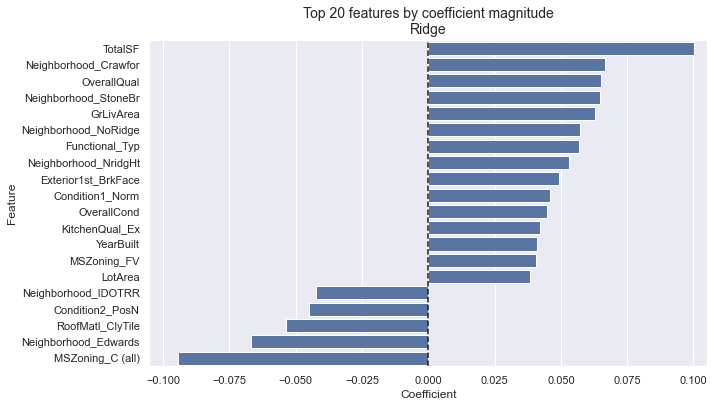

In [44]:
# fit and predict
pipe_ridge.fit(X_train, y_train)
print('Best tested param:\nalpha =', pipe_ridge['model'].regressor_.alpha_)
y_pred_ridge = pipe_ridge.predict(X_test)

# feature importances
top_feat_ridge = plot_importances(pipe_ridge)

#### Lasso

In [45]:
# LassoCV
regressor = LassoCV(cv=5, n_jobs=-1)

pipe_lasso = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
    ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1)),
])

model_list.append('Lasso')
# cross-validation
get_cv_scores(pipe_lasso)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s


RMSE: [19872. 31700. 26348. 20728. 50691.]
RMSE_mean: 29868
RMSE_std: 11250

RMSLE: [0.10432434 0.13127837 0.12374488 0.10691567 0.15111099]
RMSLE_mean: 0.123475
RMSLE_std: 0.017121


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Best tested param:
alpha = 0.0006539293757864991


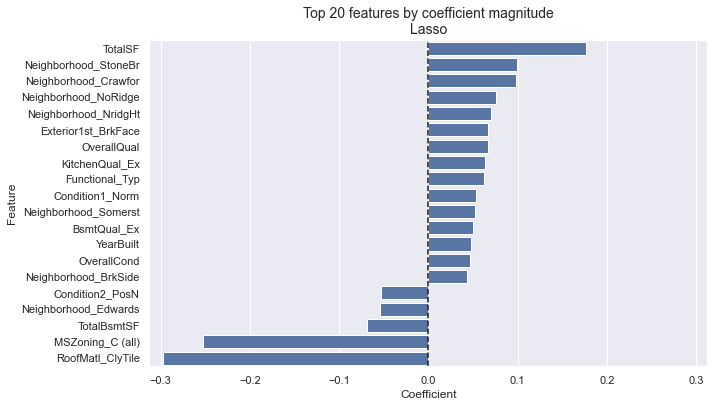

In [46]:
# fit and predict
pipe_lasso.fit(X_train, y_train)
print('Best tested param:\nalpha =', pipe_lasso['model'].regressor_.alpha_)
y_pred_lasso = pipe_lasso.predict(X_test)

# feature importances
top_feat_lasso = plot_importances(pipe_lasso)

#### ElasticNet

In [47]:
# ElasticNetCV
l1_ratios = np.concatenate(([0.05], np.arange(0.1, 0.5, 0.1), np.arange(0.5, 1.05, 0.05))).round(2)
regressor = ElasticNetCV(l1_ratio=l1_ratios, cv=5, n_jobs=-1)

pipe_en = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
    ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1)),
])

# model_list.append('ElasticNet')
# cross-validation
get_cv_scores(pipe_en, save_results=False)
# very similar results to Lasso, will constrain L1 ratio next

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.1s


RMSE: [19872. 31700. 26348. 20728. 50631.]
RMSE_mean: 29856
RMSE_std: 11228

RMSLE: [0.10432434 0.13127837 0.12374488 0.10691567 0.15108936]
RMSLE_mean: 0.123471
RMSLE_std: 0.017114


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


In [48]:
# ElasticNetCV with l1_ratio set as default 0.5
regressor = ElasticNetCV(cv=5, n_jobs=-1) 

pipe_en = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
    ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1)),
])

model_list.append('ElasticNet')
# cross-validation
get_cv_scores(pipe_en)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RMSE: [19978. 30722. 26097. 20936. 50562.]
RMSE_mean: 29659
RMSE_std: 11141

RMSLE: [0.10516627 0.1311061  0.12284242 0.1076488  0.15112813]
RMSLE_mean: 0.123578
RMSLE_std: 0.016787


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best tested param:
alpha = 0.0012197134489674865 
l1_ratio (not tested) = 0.5


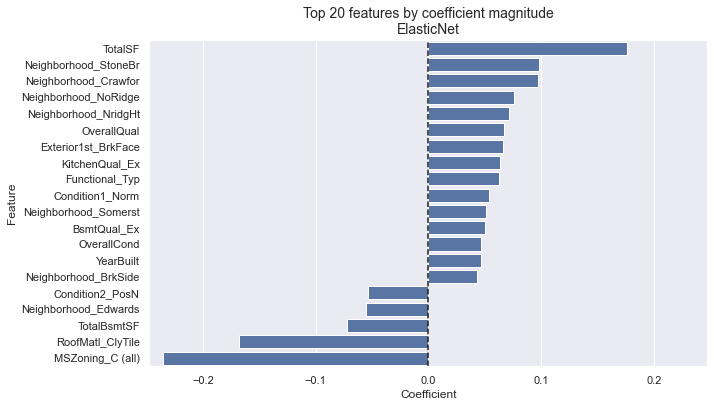

In [49]:
# fit and predict
pipe_en.fit(X_train, y_train)
print('Best tested param:\nalpha =', pipe_en['model'].regressor_.alpha_,
     '\nl1_ratio (not tested) =', pipe_en['model'].regressor_.l1_ratio_)
y_pred_en = pipe_en.predict(X_test)

# feature importances
top_feat_en = plot_importances(pipe_en)

#### Random forest

In [50]:
# tune hyperparams with optuna outside of pipeline
# regenerate preprocessed train and test set 
pipe1 = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
])
X_train2 = pipe1.fit_transform(X_train)
X_test2 = pipe1.transform(X_test)

In [51]:
# hyperparam tuning for RandomForestRegressor
def rf_objective(trial):
    _n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    _max_depth = trial.suggest_int('max_depth', 5, 50)
    _min_samp_split = trial.suggest_int('min_samples_split', 2, 10)
    _min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    # _max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    _max_features = trial.suggest_int('max_features', 2, X_train2.shape[1])

    rf = RandomForestRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        max_features=_max_features,
        n_jobs=-1,
        random_state=randomstate,
    )

    cv_score_m = cross_val_score(rf, X_train2, np.log1p(y_train), cv=5,
                                scoring='neg_root_mean_squared_error', n_jobs=-1,).mean()
    return cv_score_m

if 'best_params' not in locals():
    rf_params = tune(rf_objective)
else:
    print('Optimized parameters:', best_params['rf'])

Optimized parameters: {'n_estimators': 264, 'max_depth': 37, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 103}


In [52]:
# tuned RandomForestRegressor
if 'best_params' not in locals():
    regressor = RandomForestRegressor(**rf_params, random_state=randomstate, n_jobs=-1)
else:
    regressor = RandomForestRegressor(**best_params['rf'], random_state=randomstate, n_jobs=-1)

pipe_rf = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
    ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1)),
])

model_list.append('RandomForest')
# cross-validation
get_cv_scores(pipe_rf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s


RMSE: [24772. 31118. 31812. 22413. 32383.]
RMSE_mean: 28500
RMSE_std: 4095

RMSLE: [0.12503966 0.14810905 0.14043225 0.12706399 0.13871066]
RMSLE_mean: 0.135871
RMSLE_std: 0.008643


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


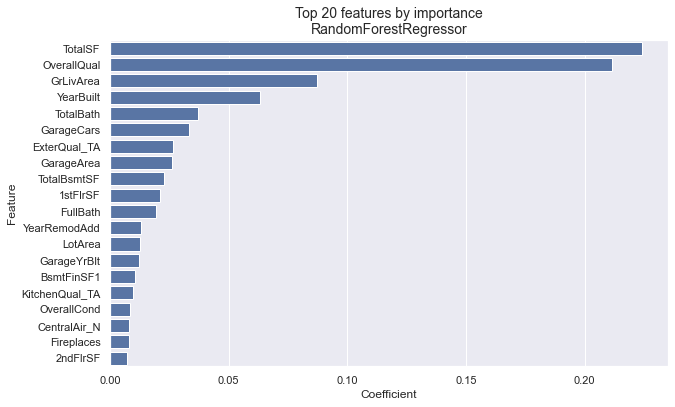

In [53]:
# fit and predict
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

# feature importances
top_feat_rf = plot_importances(pipe_rf)

#### Extra-trees regressor

In [54]:
# hyperparam tuning for ExtraTreesRegressor
def et_objective(trial):
    # _criterion = trial.suggest_categorical('criterion', ['mse', 'mae'])
    _n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    _max_depth = trial.suggest_int('max_depth', 5, 50)
    _min_samp_split = trial.suggest_int('min_samples_split', 2, 10)
    _min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    # _max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    _max_features = trial.suggest_int('max_features', 2, X_train2.shape[1])

    et = ExtraTreesRegressor(
        # criterion=_criterion,
        n_estimators=_n_estimators,
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        max_features=_max_features,
        n_jobs=-1,
        random_state=randomstate,
    )

    cv_score_m = cross_val_score(et, X_train2, np.log1p(y_train), cv=5,
                                scoring='neg_root_mean_squared_error', n_jobs=-1,).mean()
    return cv_score_m

if 'best_params' not in locals():
    et_params = tune(et_objective)
else:
    print('Optimized parameters:', best_params['et'])

Optimized parameters: {'n_estimators': 317, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 258}


In [55]:
# tuned ExtraTreesRegressor
if 'best_params' not in locals():
    regressor = ExtraTreesRegressor(**et_params, random_state=randomstate, n_jobs=-1)
else:
    regressor = ExtraTreesRegressor(**best_params['et'], random_state=randomstate, n_jobs=-1)

pipe_et = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
    ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1)),
])

model_list.append('ExtraTrees')
# cross-validation
get_cv_scores(pipe_et)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RMSE: [22684. 34425. 31352. 20472. 30445.]
RMSE_mean: 27876
RMSE_std: 5355

RMSLE: [0.11619444 0.14931173 0.14792967 0.11903989 0.13656835]
RMSLE_mean: 0.133809
RMSLE_std: 0.013970


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


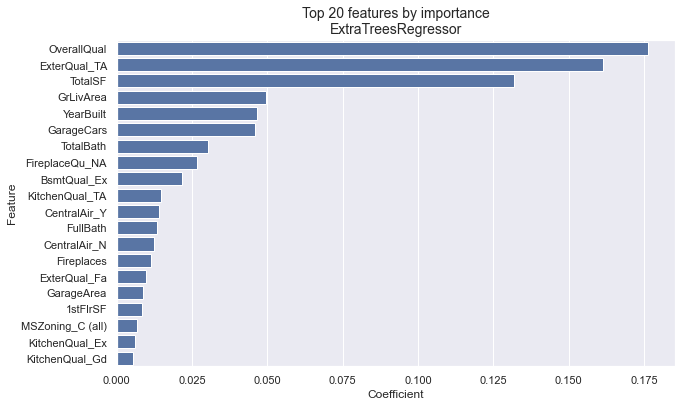

In [56]:
# fit and predict
pipe_et.fit(X_train, y_train)
y_pred_et = pipe_et.predict(X_test)

# feature importances
top_feat_et = plot_importances(pipe_et)

#### Gradient boosting regressor

In [57]:
# hyperparam tuning for GradientBoostingRegressor
def gbr_objective(trial):
    _loss = trial.suggest_categorical('loss', ['ls', 'lad', 'huber'])
    _n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    _learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    _max_depth = trial.suggest_int('max_depth', 1, 10)
    _min_samp_split = trial.suggest_int('min_samples_split', 2, 20)
    _min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    # _max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    _max_features = trial.suggest_int('max_features', 2, X_train2.shape[1])

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        random_state=randomstate,
    )

    cv_score_m = cross_val_score(gbr, X_train2, np.log1p(y_train), cv=5,
                                scoring='neg_root_mean_squared_error', n_jobs=-1,).mean()
    return cv_score_m

if 'best_params' not in locals():
    gbr_params = tune(gbr_objective)
else:
    print('Optimized parameters:', best_params['gbr'])

Optimized parameters: {'loss': 'huber', 'n_estimators': 1364, 'learning_rate': 0.019778252270952118, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 25}


In [58]:
# tuned GradientBoostingRegressor
if 'best_params' not in locals():
    regressor = GradientBoostingRegressor(**gbr_params, random_state=randomstate)
else:
    regressor = GradientBoostingRegressor(**best_params['gbr'], random_state=randomstate)

pipe_gbr = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
    ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1)),
])

model_list.append('GradientBoosting')
# cross-validation
get_cv_scores(pipe_gbr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s


RMSE: [20439. 27823. 27192. 18837. 32116.]
RMSE_mean: 25281
RMSE_std: 4936

RMSLE: [0.10217667 0.12929743 0.12249963 0.10240704 0.12869837]
RMSLE_mean: 0.117016
RMSLE_std: 0.012256


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


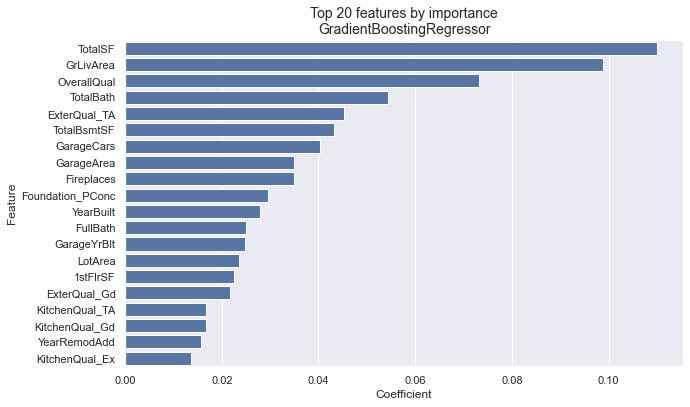

In [59]:
# fit and predict
pipe_gbr.fit(X_train, y_train)
y_pred_gbr = pipe_gbr.predict(X_test)

# feature importances
top_feat_gbr = plot_importances(pipe_gbr)

#### XGBoost

In [60]:
# hyperparam tuning for XGBRegressor
def xgb_objective(trial):
    _learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    _min_split_loss = trial.suggest_float('min_split_loss', 0, 1)
    _max_depth = trial.suggest_int('max_depth', 1, 20)
    _min_child_weight = trial.suggest_float('min_child_weight', 0.1, 10)
    _n_estimators = trial.suggest_int('n_estimators', 50, 2000)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)

    xgb = XGBRegressor(
        learning_rate=_learning_rate,
        min_split_loss=_min_split_loss,       
        max_depth=_max_depth, 
        min_child_weight=_min_child_weight,
        n_estimators=_n_estimators,
        subsample=_subsample,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=randomstate,
    )
    
    cv_score_m = cross_val_score(xgb, X_train2, np.log1p(y_train), cv=5,
                                scoring='neg_root_mean_squared_error', n_jobs=-1,).mean()
    return cv_score_m

if 'best_params' not in locals():
    xgb_params = tune(xgb_objective)
else:
    print('Optimized parameters:', best_params['xgb'])

Optimized parameters: {'learning_rate': 0.011086229731738442, 'min_split_loss': 5.246998315952783e-05, 'max_depth': 14, 'min_child_weight': 9.561748912902848, 'n_estimators': 1540, 'subsample': 0.6345257467809601, 'reg_alpha': 1.7753736634113237, 'reg_lambda': 4.300012664185616}


In [61]:
# tuned XGBRegressor
if 'best_params' not in locals():
    regressor = XGBRegressor(**xgb_params, random_state=randomstate)
else:
    regressor = XGBRegressor(**best_params['xgb'], random_state=randomstate)  

pipe_xgb = Pipeline(steps=[
    ('clean_eng', pipe_clean),
    ('preprocess', pipe_preproc),
    ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1)),
])

model_list.append('XGBoost')
# cross-validation
get_cv_scores(pipe_xgb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min


RMSE: [22191. 26075. 34504. 20183. 35433.]
RMSE_mean: 27677
RMSE_std: 6254

RMSLE: [0.11457762 0.13007219 0.13397578 0.11175683 0.13648579]
RMSLE_mean: 0.125374
RMSLE_std: 0.010213


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


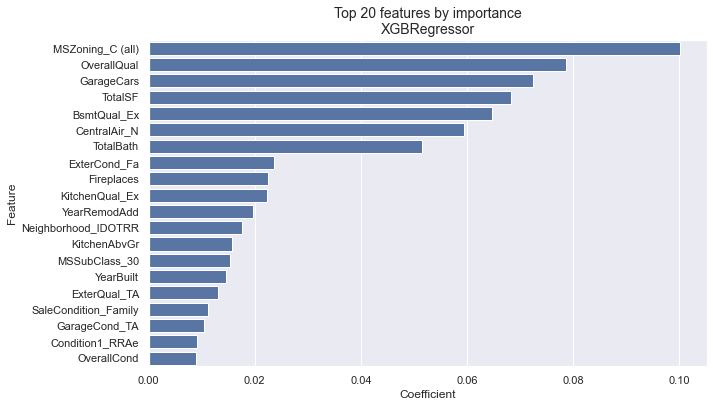

In [62]:
# fit and predict
pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)

# feature importances
top_feat_xgb = plot_importances(pipe_xgb)

#### Stacking regressor

In [63]:
# stacking generalization using StackingRegressor
# final estimator = RidgeCV (default)
stack1 = StackingRegressor(
    estimators=[
        ('ridge', Ridge(alpha=pipe_ridge['model'].regressor_.alpha_, random_state=randomstate)),
        ('lasso', Lasso(alpha=pipe_lasso['model'].regressor_.alpha_)),
        ('randomforest', pipe_rf['model'].regressor),
        ('gradientboostingregressor', pipe_gbr['model'].regressor),
    ], cv=2, n_jobs=-1, passthrough=False)

model_list.append('Stacking1')
# cross-validation
get_cv_scores2(stack1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.4s remaining:   26.1s


RMSLE: [0.10179131 0.1263009  0.11861429 0.10181538 0.13841214]
RMSLE_mean: 0.117387
RMSLE_std: 0.014204


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


In [64]:
# fit and predict
stack1.fit(X_train2, np.log1p(y_train)) 
y_pred_stack1 = np.expm1(stack1.predict(X_test2))

In [65]:
# stacking generalization using StackingRegressor
# final estimator = RidgeCV (default)
# add XGBoost
stack2 = StackingRegressor(
    estimators=[
        ('ridge', Ridge(alpha=pipe_ridge['model'].regressor_.alpha_, random_state=randomstate)),
        ('lasso', Lasso(alpha=pipe_lasso['model'].regressor_.alpha_)),
        ('randomforest', pipe_rf['model'].regressor),
        ('gradientboostingregressor', pipe_gbr['model'].regressor),
        ('xgboost', pipe_xgb['model'].regressor),
    ], cv=2, n_jobs=-1, passthrough=False)

model_list.append('Stacking2')
# cross-validation
get_cv_scores2(stack2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.5min


RMSLE: [0.10189154 0.1249598  0.11903528 0.1017905  0.13593335]
RMSLE_mean: 0.116722
RMSLE_std: 0.013305


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


In [66]:
# fit and predict
stack2.fit(X_train2, np.log1p(y_train)) 
y_pred_stack2 = np.expm1(stack2.predict(X_test2))

#### Model summary and export for submission

In [67]:
# model summary
mod_summary = pd.DataFrame({'model':model_list, 'RMSE_mean':rmse_m_list, 'RMSE_std':rmse_s_list,
                            'RMSLE_mean':rmsle_m_list, 'RMSLE_std':rmsle_s_list})
mod_summary # (RMSE not calculated for stacking as described above)

,model,RMSE_mean,RMSE_std,RMSLE_mean,RMSLE_std
0,Ridge,30848.736383,12009.213139,0.127738,0.016492
1,Lasso,29867.841368,11250.027506,0.123475,0.017121
2,ElasticNet,29659.030583,11140.598252,0.123578,0.016787
3,RandomForest,28499.539312,4095.041878,0.135871,0.008643
4,ExtraTrees,27875.602461,5354.601243,0.133809,0.013970
5,GradientBoosting,25281.355906,4935.696281,0.117016,0.012256
6,XGBoost,27677.326191,6254.300143,0.125374,0.010213
7,Stacking1,0.000000,0.000000,0.117387,0.014204
8,Stacking2,0.000000,0.000000,0.116722,0.013305


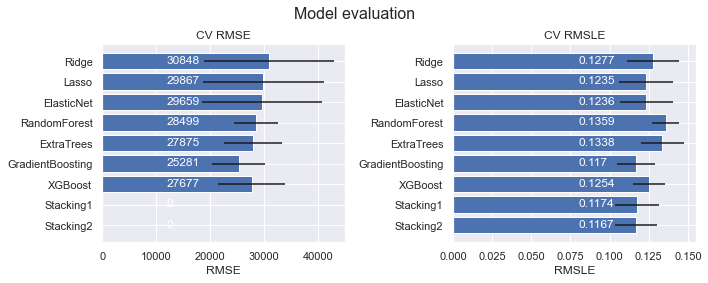

In [68]:
# visualize results
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
axs[0].barh(y='model', width='RMSE_mean', data=mod_summary, xerr='RMSE_std', color='#4C72B0')
axs[0].set(title='CV RMSE', xlabel='RMSE')
axs[1].barh(y='model', width='RMSLE_mean', data=mod_summary, xerr='RMSLE_std', color='#4C72B0')
axs[1].set(title='CV RMSLE', xlabel='RMSLE')
axs[0].invert_yaxis()
axs[1].yaxis.set_tick_params(labelleft=True)
for ii, vv in enumerate(mod_summary['RMSE_mean'].astype(int)):
    axs[0].text(12000, ii+0.1, str(vv), color='w')
for ii, vv in enumerate(mod_summary['RMSLE_mean'].round(4)):
    axs[1].text(0.08, ii+0.1, str(vv), color='w')
fig.tight_layout()
plt.suptitle('Model evaluation', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()
if save_fig:
    fig.savefig(fig_path+'model_eval.pdf', format='pdf', bbox_inches='tight')

In [69]:
# save optimized parameters from optuna
# to save computation time and for reproducibility
if 'best_params' not in locals():
    best_params = {}
    best_params['rf'] = rf_params
    best_params['et'] = et_params
    best_params['gbr'] = gbr_params
    best_params['xgb'] = xgb_params

    with open('best_params.pickle', 'wb') as fh:
        pickle.dump(best_params, fh, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
# sample submission format
sample_submission = pd.read_csv('house-prices-advanced-regression-techniques/sample_submission.csv',
                                index_col=['Id'])
sample_submission.head()

,SalePrice
Id,
1461,169277.052498
1462,187758.393989
1463,183583.683570
1464,179317.477511
1465,150730.079977


In [71]:
# export predictions 
pred_list = [y_pred_ridge, y_pred_lasso, y_pred_en, 
             y_pred_rf, y_pred_et, 
             y_pred_gbr, y_pred_xgb, 
             y_pred_stack1, y_pred_stack2]
pred_names = ['r', 'l', 'en', 'rf', 'et', 'gbr', 'xgb', 'stack1', 'stack2']

for pred_vals, pred_name in zip(pred_list, pred_names):
    submission = sample_submission.copy()
    submission['SalePrice'] = pred_vals
    submission.to_csv(sub_path+'submission_'+pred_name+'.csv')
    print('saved submission_'+pred_name+'.csv')

submission.head()

saved submission_r.csv
saved submission_l.csv
saved submission_en.csv
saved submission_rf.csv
saved submission_et.csv
saved submission_gbr.csv
saved submission_xgb.csv
saved submission_stack1.csv
saved submission_stack2.csv


,SalePrice
Id,
1461,121033.103494
1462,159986.211218
1463,187165.371830
1464,198365.443644
1465,191341.774105


#### Feature importance analysis

In [72]:
# most important features in all models 
# intersecting/common features in all top 20 lists
feature_lists = [top_feat_ridge['Feature'].to_list(), top_feat_lasso['Feature'].to_list(), 
                 top_feat_en['Feature'].to_list(), top_feat_rf['Feature'].to_list(), 
                 top_feat_et['Feature'].to_list(), top_feat_gbr['Feature'].to_list(),
                 top_feat_xgb['Feature'].to_list()]
print('Features that are in the top 20 for all models:\n', set.intersection(*map(set,feature_lists)))

Features that are in the top 20 for all models:
 {'TotalSF', 'YearBuilt', 'OverallQual'}


In [73]:
# ranking features in specifically in rf and gbr models
top_feat_rf['Rank'] = top_feat_rf['Magnitude'].rank(ascending=False)
top_feat_gbr['Rank'] = top_feat_gbr['Magnitude'].rank(ascending=False)
top_feat_rfgbr = top_feat_rf[['Feature', 'Rank']].merge(top_feat_gbr[['Feature', 'Rank']],
                                                        on='Feature', how='inner', suffixes=['_rf', '_gbr'])
top_feat_rfgbr['mean_rank'] = (top_feat_rfgbr['Rank_rf']+top_feat_rfgbr['Rank_gbr'])/2
top_feat_rfgbr.sort_values(by='mean_rank')

,Feature,Rank_rf,Rank_gbr,mean_rank
0,TotalSF,1.0,1.0,1.0
1,OverallQual,2.0,3.0,2.5
2,GrLivArea,3.0,2.0,2.5
4,TotalBath,5.0,4.0,4.5
6,ExterQual_TA,7.0,5.0,6.0
5,GarageCars,6.0,7.0,6.5
3,YearBuilt,4.0,11.0,7.5
8,TotalBsmtSF,9.0,6.0,7.5
7,GarageArea,8.0,8.0,8.0
10,FullBath,11.0,12.0,11.5
